Adding all imports here.

In [1]:
!pip install --upgrade pip
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 1.6MB 5.0MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 2.3 MB 6.9 MB/s 
     |████████████████████████████████| 895 kB 32.0 MB/s 
     |████████████████████████████████| 3.3 MB 38.4 MB/s 
     |████████████████████████████████| 1.2 MB 5.4 MB/s 


In [2]:
%matplotlib inline

import json
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import os

from transformers import BertTokenizer, TFBertModel
from tokenizers import BertWordPieceTokenizer
from transformers import AutoTokenizer, AutoConfig, TFAutoModel    
from transformers import (XLMRobertaConfig, XLMRobertaTokenizer, TFXLMRobertaModel)            

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

Configuring TPU settings

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.90.26.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.90.26.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of replicas: 8


In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Downloading the dataset from Kaggle API.

This code block creates the kaggle.json file and establishes API credentials so we can use Kaggle APIs for downloading datasets and interact with competitions, etc.

In [5]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"shuklashwin","key":"0202fbbba8d98c0d3e65da68537becf7"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c contradictory-my-dear-watson

  0% 0.00/66.0k [00:00<?, ?B/s]
100% 66.0k/66.0k [00:00<00:00, 22.2MB/s]
  0% 0.00/536k [00:00<?, ?B/s]
100% 536k/536k [00:00<00:00, 75.9MB/s]
  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 83.1MB/s]


Unzipping train and test data files.

In [7]:
!mkdir /content/data

with zipfile.ZipFile('/content/test.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/')

with zipfile.ZipFile('/content/train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/')

Reading in the CSV files.

In [8]:
train = pd.read_csv("/content/data/train.csv")
test = pd.read_csv("/content/data/test.csv")

train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1




---



Data Exploration and analysis

In [9]:
missing_values_count = train.isnull().sum()
print("Number of missing data points per column:\n")
print (missing_values_count)

Number of missing data points per column:

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64


In [10]:
print("Number of training data rows: {}".format(train.shape[0]))
print("Number of training data columns: {}".format(train.shape[1]))

Number of training data rows: 12120
Number of training data columns: 6


In [11]:
train.language.unique()
train.language.value_counts()

English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
Turkish        351
German         351
Bulgarian      342
Name: language, dtype: int64

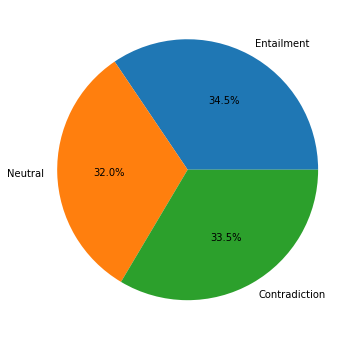

In [12]:
counts = train['label'].value_counts()

class_labels = ['Entailment', 'Neutral', 'Contradiction']

counts_per_class = [counts[0], counts[1], counts[2]]

# counts.plot(kind='barh')

plt.figure(figsize = (6,6))
plt.pie(counts_per_class,labels = class_labels, autopct = '%1.1f%%')
plt.show()



---



Splitting the training dataset into training and validation.

In [13]:
train, validation = train_test_split(train, 
                                     stratify=train.label.values, 
                                     random_state=42, 
                                     test_size=0.2, 
                                     shuffle=True)


train.reset_index(drop=True, inplace=True)
validation.reset_index(drop=True, inplace=True)

print("Train data: {}".format(train.shape))
print("Validation data: {}".format(validation.shape))

Train data: (9696, 6)
Validation data: (2424, 6)


Implementing NLI with M-BERT Model.<br>
The workflow is as follows:<br>


1.   Set up Tokenizer
2.   Configure hyperparameters
3.   Encode input sequences
4.   Create and train model
5.   Chart plots to see the performance of the model, namely<br>
    5.1.  Training vs validation loss<br>
    5.2.  Training vs validation accuracy<br>
    5.3.  Confusion matrix<br>
    5.4.  Correct predictions per language.<br>







---



## 1. Setting up M-BERT Tokenizer.

Loading the M-BERT Tokenizer and Model from the HuggingFace library.

In [14]:
model_name = 'bert-base-multilingual-cased'
mbert_tokenizer = BertTokenizer.from_pretrained(model_name)
mbert_model = TFBertModel.from_pretrained(model_name)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [15]:
mbert_tokenizer

PreTrainedTokenizer(name_or_path='bert-base-multilingual-cased', vocab_size=119547, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [16]:
mbert_model.config

BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}

Saving the BertTokenizer locally for fast loading.

In [17]:
save_path = "."
if not os.path.exists(save_path):
  os.makedirs(save_path)
mbert_tokenizer.save_pretrained(save_path)

mbert_tokenizer = BertWordPieceTokenizer("vocab.txt", lowercase=False, strip_accents=False)

In [18]:
mbert_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=False, lowercase=False, wordpieces_prefix=##)



---



### 2. Configuring hyperparameters for this model.

Now let's find out the maximum length of the input sequences in order to fix a MAX_LEN for this model.

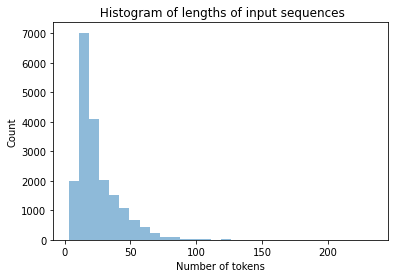

In [19]:
def plot_input_histogram(df, tokenizer):
    """
    Plot histogram of lengths of input sequences
    """
    all_text = df.premise.values.tolist() + df.hypothesis.values.tolist() # list of all string texts
    all_text_tokenized = tokenizer.encode_batch(all_text) # list of encoding objects
    all_tokenized_len = [len(encoding.tokens) for encoding in all_text_tokenized] # list of token lengths
       
    plt.hist(all_tokenized_len, bins=30, alpha=0.5)
    plt.title(' Histogram of lengths of input sequences')
    plt.xlabel('Number of tokens')
    plt.ylabel('Count')

    plt.show()

plot_input_histogram(train, mbert_tokenizer)


Since most of the premises and hypotheses are shorter than 50 tokens, we can set MAX_LEN = 100, such that we have both premises and hypotheses with maximum 50 tokens each.

Therefore, we set the following hyperparameters.

In [20]:
EPOCHS = 3
BATCH_SIZE = 64 
MAX_LEN = 100
PATIENCE = 1
LEARNING_RATE = 1e-5

### 3. Encoding input sequences.

BERT Tokenization format: `CLS` Premise `SEP` Hypothesis `SEP` <br>
The encoded input will be in the format: <input word ID, input word mask, input type ID>.

In [21]:
def encode(data, tokenizer, max_len=50):

    input_pairs = data[['premise', 'hypothesis']].values.tolist()
    tokenizer.enable_truncation(max_len)
    tokenizer.enable_padding()

    encoded_pairs = tokenizer.encode_batch(input_pairs)

    input_word_ids = tf.ragged.constant([enc.ids for enc in encoded_pairs], dtype=tf.int32)
    input_mask = tf.ragged.constant([enc.attention_mask for enc in encoded_pairs], dtype=tf.int32)
    input_type_ids = tf.ragged.constant([enc.type_ids for enc in encoded_pairs], dtype=tf.int32)

    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask.to_tensor(),
        'input_type_ids': input_type_ids.to_tensor()
    }

    return inputs

In [22]:
encoded_train = encode(train, mbert_tokenizer, max_len=MAX_LEN)

In [23]:
encoded_validation = encode(validation, mbert_tokenizer, MAX_LEN)

In [24]:
def build_model(model, max_len=50):

    tf.random.set_seed(123456)

    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

    embeddings = mbert_model([input_word_ids, input_mask, input_type_ids])[0]
    cls_vector = embeddings[:,0,:]

    output = tf.keras.layers.Dense(3, activation='softmax')(cls_vector)

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [25]:
mbert_model = build_model(model_name, MAX_LEN)
mbert_model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [26]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_filepath='bert_best_checkpoint.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)]

train_history = mbert_model.fit(x=encoded_train, y=train.label.values, validation_data=(encoded_validation, validation.label.values), epochs=EPOCHS, verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/3


152/152 [==============================] - ETA: 0s - loss: 1.0453 - accuracy: 0.4436WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


152/152 [==============================] - 1059s 7s/step - loss: 1.0447 - accuracy: 0.4441 - val_loss: 0.8250 - val_accuracy: 0.6460

Epoch 00001: val_loss improved from inf to 0.82504, saving model to bert_best_checkpoint.hdf5
Epoch 2/3
152/152 [==============================] - 1040s 7s/step - loss: 0.7653 - accuracy: 0.6671 - val_loss: 0.8210 - val_accuracy: 0.6489

Epoch 00002: val_loss improved from 0.82504 to 0.82098, saving model to bert_best_checkpoint.hdf5
Epoch 3/3
152/152 [==============================] - 1044s 7s/step - loss: 0.6040 - accuracy: 0.7554 - val_loss: 0.8005 - val_accuracy: 0.6634

Epoch 00003: val_loss improved from 0.82098 to 0.80047, saving model to bert_best_checkpoint.hdf5


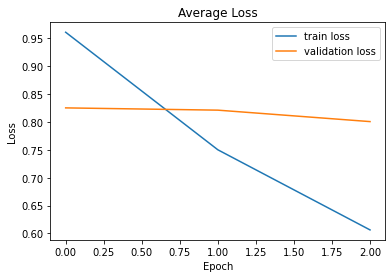

In [27]:
plt.plot(train_history.history['loss'], label='train loss')
plt.plot(train_history.history['val_loss'], label='validation loss')
plt.title('Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

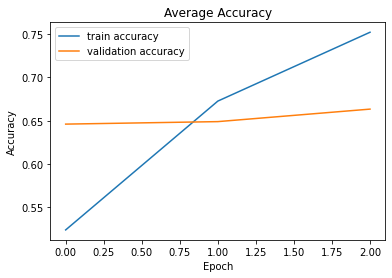

In [28]:
plt.plot(train_history.history['accuracy'], label='train accuracy')
plt.plot(train_history.history['val_accuracy'], label='validation accuracy')
plt.title('Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Classification Report
               precision    recall  f1-score   support

contradiction       0.64      0.67      0.66       813
   entailment       0.69      0.67      0.68       835
      neutral       0.66      0.65      0.65       776

     accuracy                           0.66      2424
    macro avg       0.66      0.66      0.66      2424
 weighted avg       0.66      0.66      0.66      2424



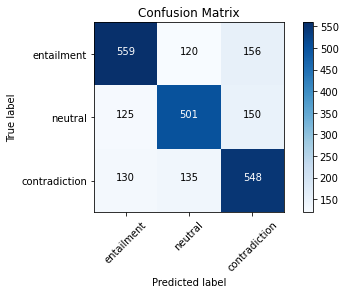

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product

# The function plot_confusion_matrix() is from scikit-learn’s website to plot the confusion matrix. 
# link: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


validation_predictions = [np.argmax(i) for i in mbert_model.predict(encoded_validation)] #predictions
validation_labels = validation.label.values.tolist() #ground truth labels

cm_plot_labels = ['entailment','neutral', 'contradiction']
cm = confusion_matrix(y_true=validation_labels, y_pred=validation_predictions)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
# plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix With Normalization', normalize=True)

target_class = ['entailment' if label==0 else 'neutral' if label==1 else 'contradiction' for label in validation_labels]
prediction_class = ['entailment' if label==0 else 'neutral' if label==1 else 'contradiction' for label in validation_predictions]
print('\nClassification Report')
print(classification_report(y_true=target_class, y_pred=prediction_class))

In [30]:
# function to print accuracy per language
def accuracy(x):
    return round(float(x[2]/x[1]), 2)*100

validation['predictions'] = validation_predictions

# Calculate the total number of examples per language
lang_counts = validation.language.value_counts().sort_index()

# Calculate the number of correct predictions per language
tp_per_lang = validation[validation['label'] == validation['predictions']].groupby('language').agg({'language': ['count']}).sort_index()

lang_names = lang_counts.index.tolist()
lang_tuples = list(zip(lang_names, lang_counts.values.tolist(), tp_per_lang.iloc[:, 0].values.tolist()))
acc = map(accuracy, lang_tuples)
for i, score in enumerate(acc):
    print ("Accuracy of {} is {} ".format(lang_tuples[i][0], score))

Accuracy of Arabic is 68.0 
Accuracy of Bulgarian is 61.0 
Accuracy of Chinese is 69.0 
Accuracy of English is 69.0 
Accuracy of French is 66.0 
Accuracy of German is 66.0 
Accuracy of Greek is 57.99999999999999 
Accuracy of Hindi is 65.0 
Accuracy of Russian is 70.0 
Accuracy of Spanish is 72.0 
Accuracy of Swahili is 56.99999999999999 
Accuracy of Thai is 45.0 
Accuracy of Turkish is 54.0 
Accuracy of Urdu is 56.99999999999999 
Accuracy of Vietnamese is 70.0 
